In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os


In [2]:
!ls '/content/drive/My Drive/'


 05-17-2024_slides.gslides
'540 research presentation.gslides'
 a
 ckp
'Colab Notebooks'
 FrgualGPT.gslides
'Harmonizing Flows: Unsupervised MR harmonization based on normalizing flows.gslides'
'shuaiming@ucsb.edu 2024-03-21 20:52'
 Sketcher-Refiner.gslides
'Untitled presentation (1).gslides'
'Untitled presentation (2).gslides'
'Untitled presentation (3).gslides'
'Untitled presentation.gslides'
 WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
# Set the path to the main folder
dataset_dir = '/content/drive/My Drive/a/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Get class names
class_names = dataset.classes

# Print class names
print("Class names:", class_names)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Class names: ['abbey', 'airplane_cabin', 'airport_terminal', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'anechoic_chamber', 'apartment_building', 'aquarium', 'aqueduct', 'arch', 'archive', 'art_gallery', 'art_school', 'art_studio', 'assembly_line', 'attic', 'auditorium', 'auto_factory']


In [6]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 20),
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

model, criterion, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]


In [ ]:
num_epochs = 20
losses_per_epoch = []
save_dir = "/content/drive/My Drive/ckp"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as batch_progress:
        for inputs, labels in batch_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar with the current loss
            batch_progress.set_postfix(loss=running_loss/len(train_loader))
    # Calculate the average loss for the current epoch
    epoch_loss = running_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

    save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss,
    }, save_path)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')


# Evaluation

<ipython-input-8-dcb531a689ca>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Evaluating: 100%|██████████| 42/42 [05:41<00:00,  8.

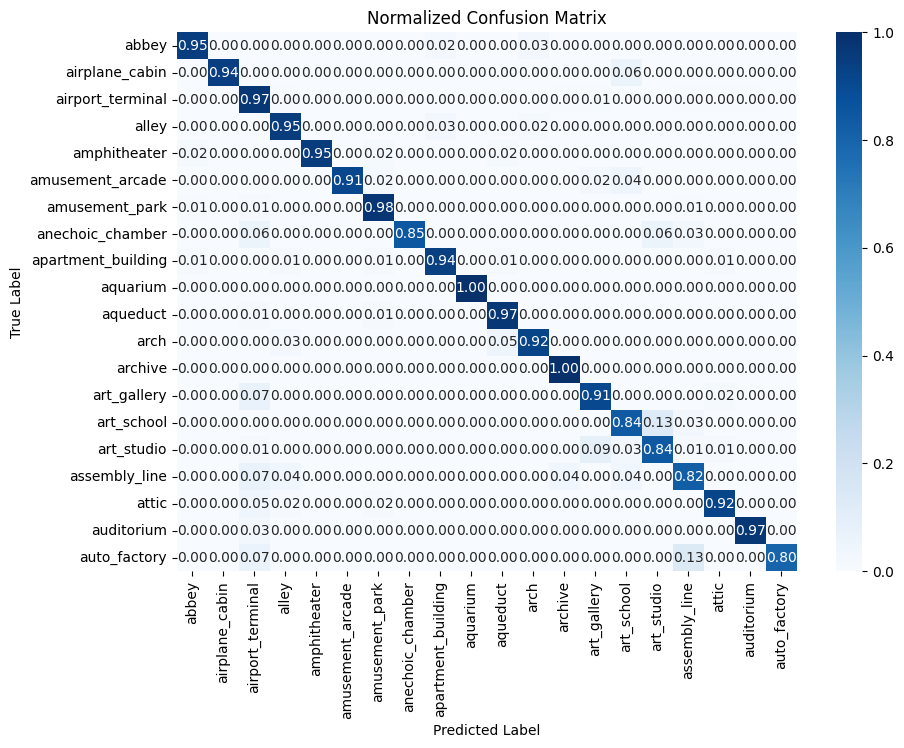

In [8]:
checkpoint_path = '/content/drive/My Drive/my_ckp/model_epoch_20.pth'

# Load the saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        # Move inputs and labels to device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Append true and predicted labels to respective lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix to range [0, 1]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.show()


In [9]:
print("\nLoss for each epoch:")
for epoch, loss in enumerate(losses_per_epoch, 1):
    print(f"Epoch {epoch}: {loss}")


Loss for each epoch:
Epoch 1: 1.7526546372544198
Epoch 2: 0.904771743253583
Epoch 3: 0.7083487226849511
Epoch 4: 0.6032719977554821
Epoch 5: 0.5418111644685268
Epoch 6: 0.48033507771435235
Epoch 7: 0.44989319429511115
Epoch 8: 0.4105973881004112
Epoch 9: 0.38798386319762185
Epoch 10: 0.3570089393428394
Epoch 11: 0.34029978345192613
Epoch 12: 0.3091936769806558
Epoch 13: 0.296108887575212
Epoch 14: 0.2702369182592347
Epoch 15: 0.2538421493289726
Epoch 16: 0.2388873743336825
Epoch 17: 0.22349584018368096
Epoch 18: 0.21677474843870317
Epoch 19: 0.2068270108928638
Epoch 20: 0.1785123770103036


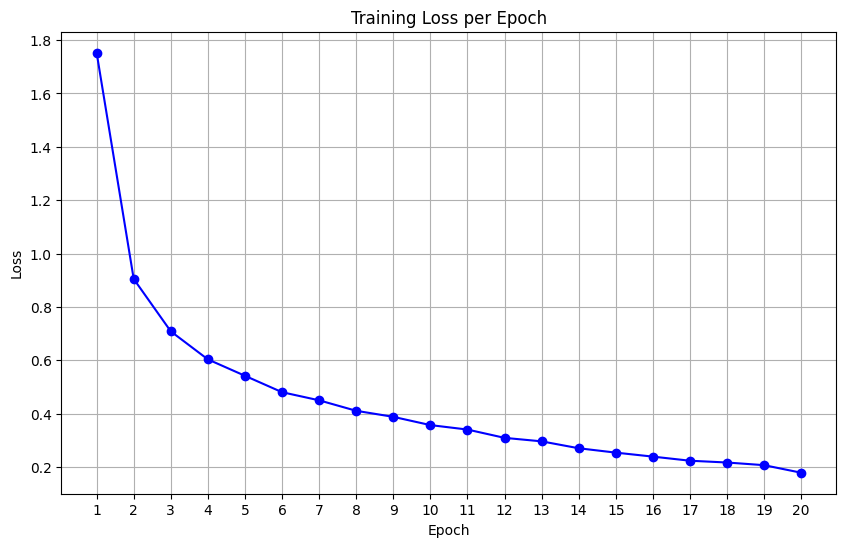

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, len(losses_per_epoch) + 1))  # Set x-axis ticks for each epoch
plt.show()

In [10]:
# Calculate accuracy for the last epoch
correct_predictions = 0
total_predictions = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(train_loader, desc="Evaluating last epoch"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate accuracy
last_epoch_accuracy = correct_predictions / total_predictions * 100  # Convert to percentage

# Print accuracy for the last epoch
print(f"Accuracy for the last epoch [{epoch}]: {last_epoch_accuracy:.2f}%")

Evaluating last epoch: 100%|██████████| 168/168 [02:08<00:00,  1.31it/s]

Accuracy for the last epoch [20]: 97.20%
